In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

Using backend: pytorch


In [2]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges() // 2)
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [4]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [5]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [6]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [7]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):

        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        x = self.W2(F.relu(self.W1(h)))

        return {'score': x.squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [8]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
pred = MLPPredictor(16)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [9]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))
        all_logits.append(['{} {}'.format(e, loss)])

from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))


In epoch 0, loss: 0.7324531674385071
In epoch 5, loss: 0.6366369128227234
In epoch 10, loss: 0.616934597492218
In epoch 15, loss: 0.6114805340766907
In epoch 20, loss: 0.6083627343177795
In epoch 25, loss: 0.5977556705474854
In epoch 30, loss: 0.584978461265564
In epoch 35, loss: 0.564764142036438
In epoch 40, loss: 0.537887454032898
In epoch 45, loss: 0.5147338509559631
In epoch 50, loss: 0.49310532212257385
In epoch 55, loss: 0.47290053963661194
In epoch 60, loss: 0.4565756320953369
In epoch 65, loss: 0.4407488703727722
In epoch 70, loss: 0.4260455369949341
In epoch 75, loss: 0.4103819727897644
In epoch 80, loss: 0.395725280046463
In epoch 85, loss: 0.38308894634246826
In epoch 90, loss: 0.36986449360847473
In epoch 95, loss: 0.3573586642742157
AUC 0.6553958805956739


In [11]:
from plotnine import *
import matplotlib.pyplot as plt
import pandas as pd
def linkPredGraph(all_logits):
    df = pd.DataFrame(all_logits) 
    df[['epoch','loss']] = df[0].str.split(expand=True) 
    del df[0]
    df.epoch = df.epoch.astype(float)
    df.loss = df.loss.astype(float)
    g = ggplot(df, aes(x='epoch', y='loss')) + geom_line() + labs(title = "loss per epoch") + geom_point(df)
    g.draw()

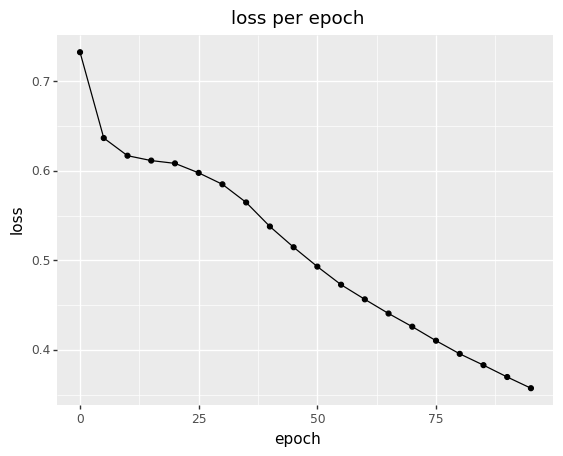

In [12]:
linkPredGraph(all_logits)